In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib

def read_csv_files(directory):
    data_frames = {}
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, filename))
            parts = filename.split('_')
            # parts[0] = which data, parts[1] = who, parts[2] = difficulty
            file_type = parts[0]
            participant = parts[-2] if len(parts) > 2 else 'unknown'
            difficulty = parts[-1].split('.')[0] if len(parts) > 1 else 'unknown'
            if participant == 'participant1'and not file_type == 'E4 ACC data':
                key = (participant, difficulty, file_type)
                data_frames[key] = df
                
    return data_frames

def preprocess_data(df):
    idx = df[df['Participant Name'] == 'game start'].index[0]
    df = df.drop(index=df.index[:idx])
    if 'E4 TMP' in df.columns:
        df = df.drop(columns = ['E4 TMP'])
    elif 'E4 BVP' in df.columns:
        df = df.drop(columns = ['E4 BVP'])
    
    return df

# 1초 단위로 나눈 dataframe을 받아서 1초 단위로 달라지는 10초짜리 프레임을 가진 데이터 프레임 만들고 arithmetic feature 추가
def make_value(df):
    column_name = df.columns.tolist()
    column_name.remove('Participant Name')
    column_name.remove('UNIX Time')
    column_name_result = []
    for i in column_name:
        column_name_result.extend([f'{i} 1', f'{i} 2', f'{i} 3', f'{i} 4', f'{i} 5', f'{i} 6', f'{i} 7', f'{i} 8', f'{i} 9', f'{i} 10'])
        column_name_result.extend([f'{i} Mean', f'{i} Min', f'{i} Max', f'{i} Std'])
        
    data_frame = pd.DataFrame(columns = column_name_result)
    
    df = df.drop(columns = ['Participant Name', 'UNIX Time'])
    
    x = 0
    while x + 10 < len(df):
        new_row = {}
        for i, col in enumerate(df.columns):
            arith = []
            for j in range(x, x + 10):
                new_row[f'{col} {j - x + 1}'] = df.iloc[j, i]
                arith.append(df.iloc[j, i])
            new_row[f'{col} Mean'] = np.mean(arith)
            new_row[f'{col} Min'] = np.min(arith)
            new_row[f'{col} Max'] = np.max(arith)
            new_row[f'{col} Std'] = np.std(arith)
        x += 1
        data_frame.loc[len(data_frame)] = new_row
    
    return data_frame

# 1초 단위로 나눈 dataframe 만들기
def process_data(df):
    time_window = 1
    df = preprocess_data(df)
    
    data_frame = pd.DataFrame(columns = df.columns.tolist())
    
    idx_before = df[df['Participant Name'] == 'game start'].index[0] + 1
    
    while idx_before + 1 < len(df):
        time = df.loc[idx_before + 1, 'UNIX Time']
        idx_range = df[(df['UNIX Time'] >= time) & (df['UNIX Time'] < time + time_window)].index
        if len(idx_range) == 0:
            break
    
        value = df.loc[idx_before + 1 : idx_range[-1]]
        value = value.median().to_dict()
        
        idx_before = idx_range[-1]

        data_frame.loc[len(data_frame)] = value
    
    result = make_value(data_frame)
    return result
    
if __name__ == "__main__":
    directory = r'C:\Users\USER\Downloads\CSV'  # Use raw string literal
    data_frames = read_csv_files(directory)
    df_data = []
    difficulty_data = []
    
    for (participant, difficulty, file_type), df in data_frames.items():
        df = process_data(df)
        df = df.reset_index(drop=True)
        df_data.append(df)
        difficulty_data.append(difficulty)
    
    # Difficulty = [difficult, easy, moderate]
    
    df_difficult = pd.concat([df_data[0], df_data[3], df_data[6], df_data[9]], axis = 1)
    df_easy = pd.concat([df_data[1], df_data[4], df_data[7], df_data[10]], axis = 1)
    df_moderate = pd.concat([df_data[2], df_data[5], df_data[8], df_data[11]], axis = 1)
    
    df_easy['Difficulty'] = 'easy'
    df_moderate['Difficulty'] = 'moderate'
    df_difficult['Difficulty'] = 'difficult'
    
    df_all = pd.concat([df_easy, df_moderate, df_difficult], axis = 0)
    
    rf_model = RandomForestClassifier()
    x = df_all.drop(columns = ['Difficulty'])
    x.fillna(x.mean(), inplace=True)
    y = df_all[['Difficulty']]
    
    x_list = [x.iloc[i].tolist() for i in range(len(x))]
    y_list = [y.iloc[i].tolist() for i in range(len(y))]
    
    x_train = np.array(x_list)
    y_train = np.array(y_list)
    
    rf_model.fit(x_train, y_train)
    
    result = rf_model.predict(np.array(x_list[0]).reshape(1, -1))
    
    print(result)
    
    joblib_file = "random_forest_model.joblib"
    joblib.dump(rf_model, joblib_file)
    print(f"Model saved as {joblib_file}")

c:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


['easy']
Model saved as random_forest_model.joblib



Reading CSV files:
  Reading: differential_cy_easier.csv
  Reading: differential_cy_easy.csv
  Reading: differential_cy_hard.csv
  Reading: differential_cy_harder.csv
  Reading: differential_cy_moderate.csv
  Reading: differential_dh_easier.csv
  Reading: differential_dh_easy.csv
  Reading: differential_dh_hard.csv
  Reading: differential_dh_harder.csv
  Reading: differential_dh_moderate.csv
  Reading: differential_gb_easier.csv
  Reading: differential_gb_easy.csv
  Reading: differential_gb_hard.csv
  Reading: differential_gb_harder.csv
  Reading: differential_gb_moderate.csv
  Reading: differential_jj_easier.csv
  Reading: differential_jj_easy.csv
  Reading: differential_jj_hard.csv
  Reading: differential_jj_harder.csv
  Reading: differential_jj_moderate.csv
  Reading: differential_jw_easier.csv
  Reading: differential_jw_easy.csv
  Reading: differential_jw_hard.csv
  Reading: differential_jw_harder.csv
  Reading: differential_jw_moderate.csv
  Reading: differential_kb_easier.csv
  

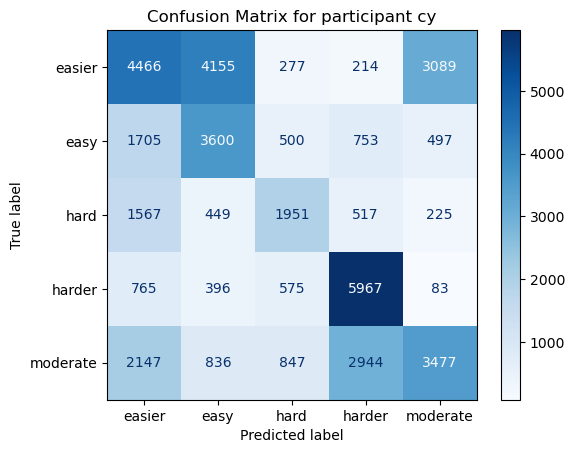


LOSO Iteration 2/11
Test participant: dh
Training model...
Evaluating model...
Accuracy for participant dh: 0.5633


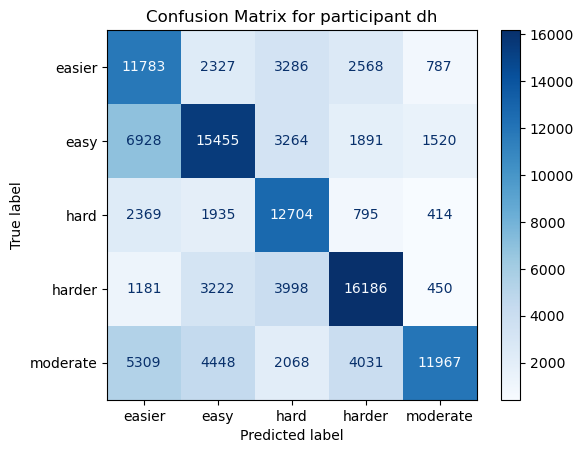


LOSO Iteration 3/11
Test participant: gb
Training model...
Evaluating model...
Accuracy for participant gb: 0.5835


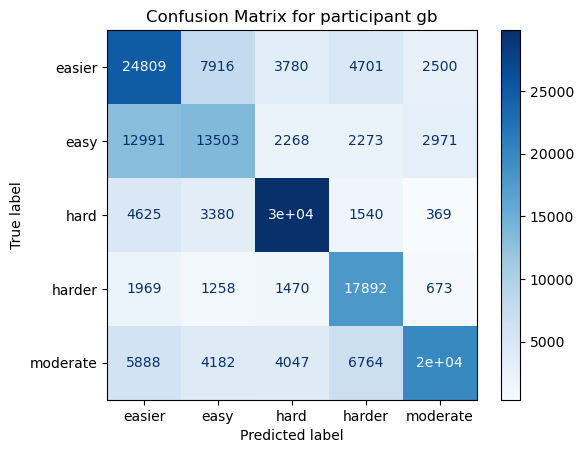


LOSO Iteration 4/11
Test participant: jj
Training model...
Evaluating model...
Accuracy for participant jj: 0.5279


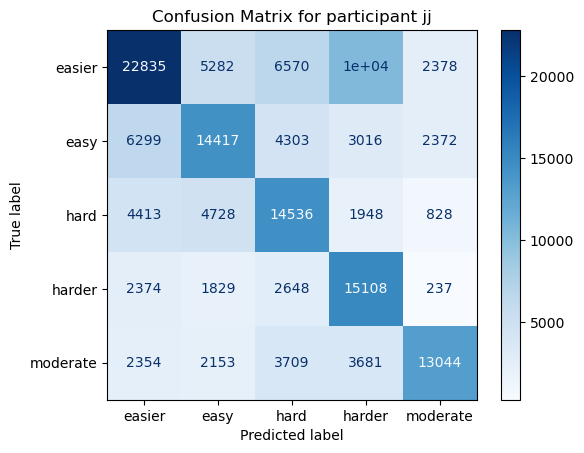


LOSO Iteration 5/11
Test participant: jw
Training model...
Evaluating model...
Accuracy for participant jw: 0.5017


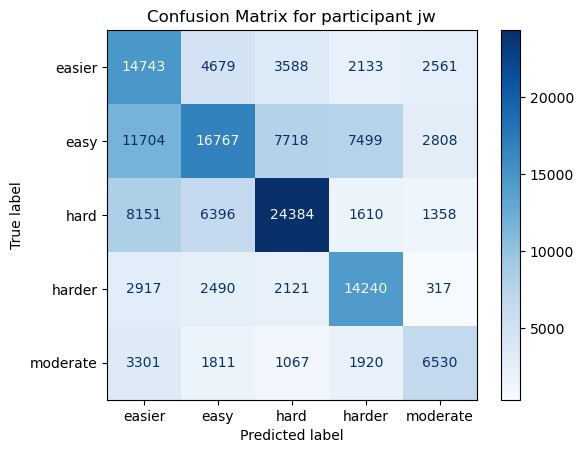


LOSO Iteration 6/11
Test participant: kb
Training model...
Evaluating model...
Accuracy for participant kb: 0.5352


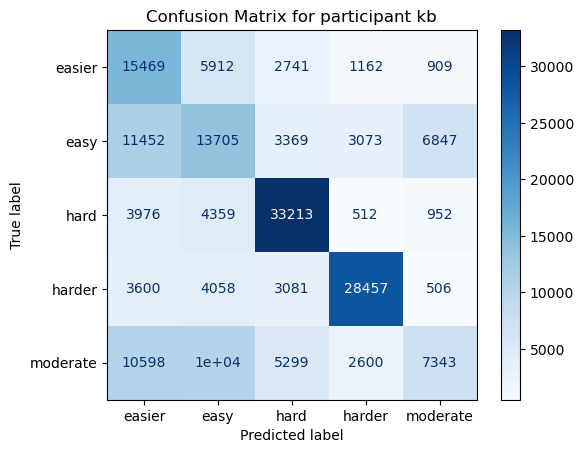


LOSO Iteration 7/11
Test participant: kw
Training model...
Evaluating model...
Accuracy for participant kw: 0.5289


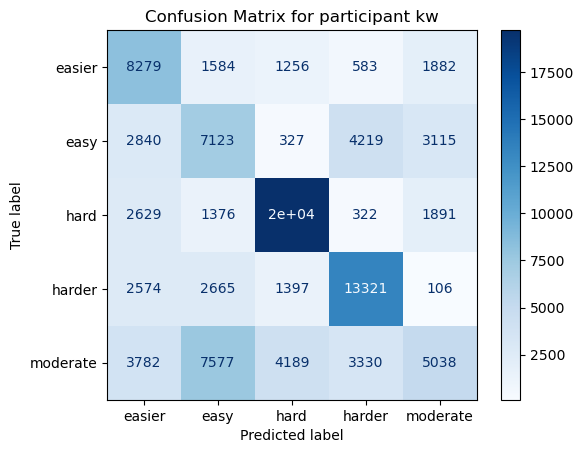


LOSO Iteration 8/11
Test participant: mw
Training model...
Evaluating model...
Accuracy for participant mw: 0.5544


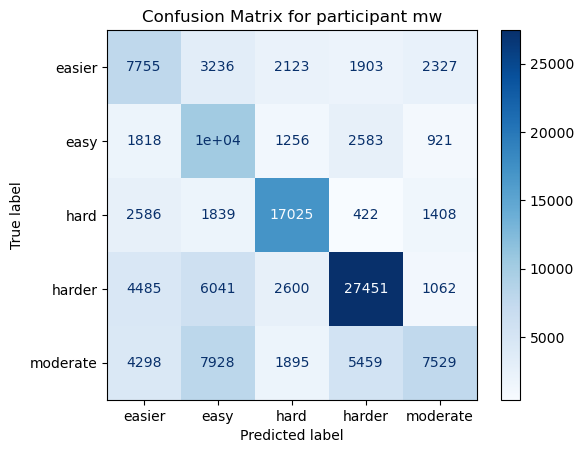


LOSO Iteration 9/11
Test participant: sh
Training model...
Evaluating model...
Accuracy for participant sh: 0.5356


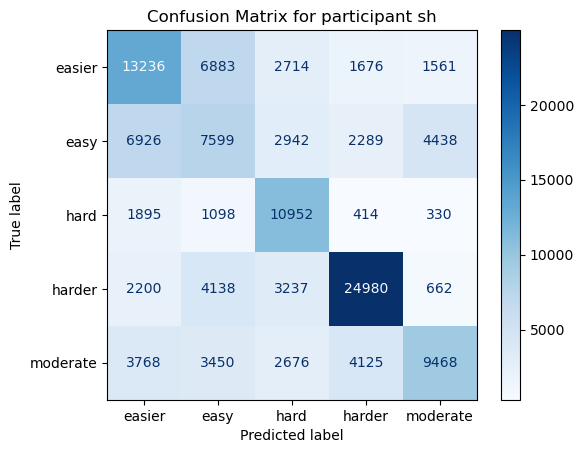


LOSO Iteration 10/11
Test participant: sm
Training model...
Evaluating model...
Accuracy for participant sm: 0.4786


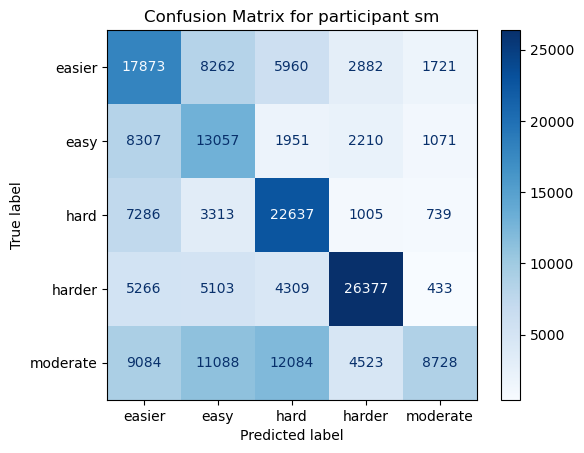


LOSO Iteration 11/11
Test participant: ym
Training model...
Evaluating model...
Accuracy for participant ym: 0.4607


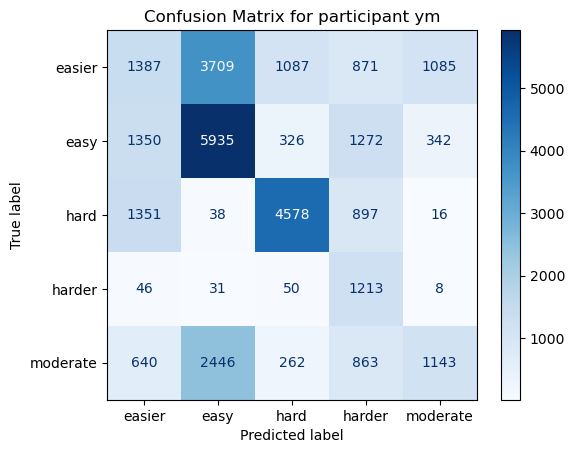

Mean accuracy: 0.5212, Standard deviation: 0.0387


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import warnings
import matplotlib.pyplot as plt

# csv 파일 읽기기
def read_csv_files(directory):
    data_frames = {}
    print("\nReading CSV files:")
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            print(f"  Reading: {filename}")
            df = pd.read_csv(os.path.join(directory, filename))
            parts = filename.split('_')
            file_type = parts[0]
            participant = parts[-2] if len(parts) > 2 else 'unknown'
            difficulty = parts[-1].split('.')[0] if len(parts) > 1 else 'unknown'
            if not file_type == 'E4 ACC data':
                key = (participant, difficulty, file_type)
                data_frames[key] = df
            else:
                print(f"    Skipped: {filename} (ACC data)")
    print(f"Total files read: {len(data_frames)}")
    return data_frames

# UNIX Time 자르기
def process_data(df):
    if 'started' in df['game started'].values:
        idx = df[df['game started'] == 'started'].index[0]
        df = df.iloc[idx:]
    else:
        print("Warning: 'game start' marker not found. Using all data.")
    
    warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
    
    if 'UNIX Time' not in df.columns or df['UNIX Time'].isnull().all():
        print("Error: 'UNIX Time' column not found or all values are null")
        return pd.DataFrame()
    
    game_start_time = df['UNIX Time'].min() + 30
    df_after_start = df[df['UNIX Time'] >= game_start_time]
    
    if df_after_start.empty:
        print(f"Warning: No data available after assumed game start")
        return pd.DataFrame()
    
    df_numeric = df_after_start.select_dtypes(include=[np.number]).drop(columns=['UNIX Time'])
    
    return df_numeric

# window size 크기로 잘라서 sequence로 만들기
def make_sequences(df, window_size):
    sequences = []
    for i in range(0, len(df) - window_size + 1):
        sequences.append(df.iloc[i:i+window_size].values.flatten())
    return np.array(sequences)

# 훈련 데이터셋 X_train, Y_train 만들기
def make_dataset(data_frames, window_size):
    X_data = []
    y_data = []
    participant_data = []
    all_columns = set()
    
    for (participant, difficulty, file_type), df in data_frames.items():
        processed_df = process_data(df)
        all_columns.update(processed_df.columns)
    
    all_columns = sorted(list(all_columns))  # Limit to expected number of features
    
    for (participant, difficulty, file_type), df in data_frames.items():
        processed_df = process_data(df)
        
        for col in all_columns:
            if col not in processed_df.columns:
                processed_df[col] = 0
        
        processed_df = processed_df[all_columns]
            
        sequences = make_sequences(processed_df, window_size)
        if len(sequences) > 0:
            X_data.append(sequences)
            y_data.extend([difficulty] * len(sequences))
            participant_data.extend([participant] * len(sequences))
    
    X_train = np.concatenate(X_data)
    Y_train = np.array(y_data)
    participants = np.array(participant_data)
    
    return X_train, Y_train, participants

# 5-fold cross validation과 하이퍼 파라미터 조정을 통해서 학습 및 정확도 출력
def KFold_train_model(X_train, Y_train):
    print("Training started from now")
    
    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }
    
    # 5-Fold Cross Validation with GridSearchCV
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    
    for i, (train_idx, test_idx) in enumerate(kf.split(X_train, Y_train)):
        print(f"\nStratified K-Fold Iteration {i+1}/5")
        X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
        Y_train_fold, Y_test_fold = Y_train[train_idx], Y_train[test_idx]
        
        rf = RandomForestClassifier(random_state=42)
        rf.fit(X_train_fold, Y_train_fold)
        
        y_pred = rf.predict(X_test_fold)
        accuracy = accuracy_score(Y_test_fold, y_pred)
        accuracies.append(accuracy)
    
    # Output the results
    print(f'Average Accuracy: {np.mean(accuracies):.4f}')

# Assume X, y, participants have been defined previously
def loso_evaluation_rf(X, y, participants):
    logo = LeaveOneGroupOut()
    loso_scores = []
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    smote = SMOTE(random_state=42)
    X, y_resampled = smote.fit_resample(X, y)
    
    # Adjust participants array to match resampled data
    print("Adjusting participants array...")
    participants_resampled = []
    for label in np.unique(y):
        original_indices = np.where(y == label)[0]
        resampled_count = np.sum(y_resampled == label)
        participants_for_label = participants[original_indices]
        if len(participants_for_label) > 0:
            participants_resampled.extend(np.repeat(participants_for_label, resampled_count // len(participants_for_label)))
            remainder = resampled_count % len(participants_for_label)
            if remainder > 0:
                participants_resampled.extend(np.random.choice(participants_for_label, size=remainder, replace=True))
    
    participants = np.array(participants_resampled)
    
    rf_params = {
        'n_estimators': 200,
        'max_depth': None,
        'random_state': 42
    }
    
    xgb_params = {
        'n_estimators': 200
    }
    
    print(f"X shape: {X.shape}")
    print(f"y shape: {y_resampled.shape}")
    print(f"participants shape: {participants.shape}")
    
    for i, (train_index, test_index) in enumerate(logo.split(X, y_resampled, participants)):
        print(f"\nLOSO Iteration {i+1}/{len(np.unique(participants))}")
        print(f"Test participant: {participants[test_index[0]]}")
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_resampled[train_index], y_resampled[test_index]
        
        rf_model = RandomForestClassifier(**rf_params)
        xgb_model = XGBClassifier(**xgb_params)
        
        voting_model = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='hard')
        
        print("Training model...")
        voting_model.fit(X_train, y_train)
        
        print("Evaluating model...")
        y_pred = voting_model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        loso_scores.append(accuracy)
        print(f"Accuracy for participant {participants[test_index[0]]}: {accuracy:.4f}")
        
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for participant {participants[test_index[0]]}')
        plt.show()
    
    print(f"Mean accuracy: {np.mean(loso_scores):.4f}, Standard deviation: {np.std(loso_scores):.4f}")

def z_score_normalization(X):
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    return X_normalized

def main():
    directory = r'C:\Users\USER\Downloads\pilotdata'
    data_frames = read_csv_files(directory)
    
    window_size = 10
    
    X_train, Y_train, participants = make_dataset(data_frames, window_size)
    X_train = np.nan_to_num(X_train, nan=0.0)
    
    if X_train is None or Y_train is None:
        print("Failed to create dataset.")
        return
    
    print(f"Dataset shape: {X_train.shape}")
    
    X_train = z_score_normalization(X_train)
    
    loso_evaluation_rf(X_train, Y_train, participants)
    
if __name__ == "__main__":
    main()